# Et si on utilisait un réseau de neurones pour trouver une bonne base ?

In [1]:
import torch
import pytorch_lightning as pl
from scipy.io import arff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import matplotlib as mpl
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
from pytorch_lightning.callbacks import EarlyStopping
%matplotlib inline

## Same as usual, importation des données et spit du dataset

In [2]:
data = arff.loadarff('data/tecator.arff')

In [3]:
df = pd.DataFrame(data[0])
df.head()

,absorbance_1,absorbance_2,absorbance_3,absorbance_4,absorbance_5,absorbance_6,absorbance_7,absorbance_8,absorbance_9,absorbance_10,...,principal_component_16,principal_component_17,principal_component_18,principal_component_19,principal_component_20,principal_component_21,principal_component_22,moisture,fat,protein
0,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,...,0.233876,0.899661,-0.042006,0.708717,-0.254173,-0.391579,-0.419313,60.5,22.5,16.7
1,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.86060,2.86566,2.87093,2.87661,...,-0.195980,-0.046359,-0.634996,-0.354403,0.014650,0.269542,0.096692,46.0,40.1,13.5
2,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,...,0.795466,0.762246,-1.268580,0.690588,-0.785592,-0.671237,-0.710290,71.0,8.4,20.5
3,2.82286,2.82460,2.82630,2.82814,2.83001,2.83192,2.83392,2.83606,2.83842,2.84097,...,0.616500,-0.388684,-2.068390,1.276160,-0.259437,-0.140206,-0.165963,72.8,5.9,20.7
4,2.78813,2.78989,2.79167,2.79350,2.79538,2.79746,2.79984,2.80254,2.80553,2.80890,...,-1.095540,-1.348450,0.453559,0.402624,0.031307,0.021824,0.145777,58.3,25.5,15.5


In [4]:
X_abs = df.iloc[:, :100]
X_pca = df.iloc[:, 100:122]
mois = df.iloc[:,-3]
fat = df.iloc[:, -2]
protein = df.iloc[:, -1]

In [5]:
X_train_abs = X_abs.iloc[:173]

y_train = fat.iloc[:173]
X_test_abs = X_abs.iloc[173:216]
y_test = fat.iloc[173:216]

In [6]:
norm = mpl.colors.Normalize(vmin=0, vmax=0.6)
cmap = cm.jet

m = cm.ScalarMappable(norm=norm, cmap=cmap)

J'utilise personnellement Pytorch et Pytorch lightning pour manipuler des réseaux de neurones.  

Plus bas, la classe pour les données

In [7]:
EPS= 1e-4
class torchDataset(Dataset):
    def __init__(self, features: np.ndarray, target: np.ndarray, grad : bool = True):
        super().__init__()
        self.features = torch.tensor(features)
        self.target = torch.tensor(target)
        self.grad = grad
        
    def __len__(self):
        return self.features.size(0)
    
    def __getitem__(self, idx:int):
        if self.grad:
            return self.normalization(torch.gradient(self.features[idx], dim=0)[0]).float(), self.target[idx].unsqueeze(0).float()/100
        return self.normalization(torch.gradient(self.features[idx], dim=0)[0]).float(), self.target[idx].unsqueeze(0).float()/100

    @staticmethod
    def normalization(input_tensor):
        return (input_tensor - torch.mean(input_tensor))/(torch.std(input_tensor)+ EPS)

Ici, je définis un simple MLP 3 couches

In [8]:
class mlp(nn.Module):
    def __init__(self, features_init: int, latent_size : int):
        super().__init__()
        self.features_init = features_init
        self.latent_size = latent_size
        self.linear_in = nn.Linear(in_features=features_init, out_features=latent_size)
        self.linear_mid = nn.Linear(in_features=latent_size, out_features=latent_size)
        self.linear_out = nn.Linear(in_features=latent_size, out_features=1)

    
    def forward(self, inputs):
        x = self.linear_in(inputs)
        x = F.relu(x)
        x = self.linear_mid(x)
        x = F.relu(x)
        return self.linear_out(x)


Et un autoencodeur. C'est grâce à l'espace latent de ce dernier que l'on pourra définir une nouvelle représentation des données.  
Pour eviter de l'overfitting, je rajoute des couches de dropout

In [9]:
class tiny_AE(nn.Module):
    def __init__(self, features_init: int, latent_size : int):
        super().__init__()
        self.features_init = features_init
        self.latent_size = latent_size
        self.encoder_in = nn.Linear(in_features=features_init, out_features=32)
        self.drop_enc = nn.Dropout(p=0.5)
        self.encoder_out = nn.Linear(in_features=32, out_features=latent_size)
        self.decoder_in = nn.Linear(in_features=latent_size, out_features=32)
        self.decorder_out = nn.Linear(in_features=32, out_features=features_init)
        self.drop_dec = nn.Dropout(p=0.5)

    
    def forward(self, inputs):
        x = self.encoder_pass(inputs)
        return self.decoder_pass(x), x
    
    def encoder_pass(self, inputs):
        x = self.encoder_in(inputs)
        x = F.relu(x)
        x = self.drop_enc(x)
        x = self.encoder_out(x)
        return torch.tanh(x)
    
    def decoder_pass(self, latent):
        x = self.decoder_in(latent)
        x = F.relu(x)
        x = self.drop_dec(x)
        return self.decorder_out(x)
        

In [10]:
class pl_AE(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = tiny_AE(100, 6)
        
    def forward(self, inputs):
        reco, _ = self.model(inputs)
        return reco
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self(x)
        loss = F.l1_loss(x_hat, x)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self(x)
        val_loss = F.l1_loss(x_hat, x)
        self.log("val_loss", val_loss)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer
    
class pl_mlp(pl.LightningModule):
    def __init__(self, model_AE):
        super().__init__()
        self.latent_creator = model_AE
        self.regressor = mlp(model_AE.latent_size, latent_size=6)
        
    def forward(self, inputs):
        with torch.no_grad():
            latent = self.latent_creator.encoder_pass(inputs)
        return self.regressor(latent)
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.mse_loss(y_hat, y)
        self.log("val_loss", val_loss)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.regressor.parameters(), lr=1e-4)
        return optimizer
    
class pl_parallel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.AE = tiny_AE(100, 6)
        self.regressor = mlp(self.AE.latent_size, latent_size=6)
        
    def forward(self, inputs):
        reco, latent = self.AE(inputs)
        return self.regressor(latent), reco
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, x_hat = self(x)
        loss = F.l1_loss(y_hat, y)
        loss += F.l1_loss(x_hat, x)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, x_hat = self(x)
        val_loss = F.l1_loss(x_hat, x)
        self.log("val_loss", val_loss)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [11]:
train_dataset = torchDataset(np.gradient(X_train_abs.to_numpy(), axis=1), y_train.to_numpy())
val_dataset = torchDataset(np.gradient(X_test_abs.to_numpy(), axis=1), y_test.to_numpy())

Un simple sanity check

In [12]:
features, fat = train_dataset[0]

In [13]:
fat

tensor([0.2250])

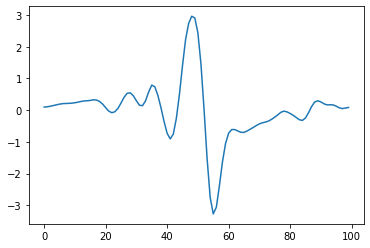

In [14]:
plt.plot(features)

In [15]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=16)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=16)

# entrainement du AE seul

In [16]:
pl_model = pl_AE()
trainer_AE = pl.Trainer(max_epochs=300, gpus=0)


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [17]:
trainer_AE.fit(pl_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


  | Name  | Type    | Params
----------------------------------
0 | model | tiny_AE | 7.0 K 
----------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)


Epoch 0:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 11/14 [00:00<00:00, 143.31it/s, loss=0.59, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 1:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 11/14 [00:00<00:00, 149.94it/s, loss=0.569, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 2:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 11/14 [00:00<00:00, 143.45it/s, loss=0.538, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 3:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 11/14 [00:00<00:00, 142.02it/s, loss=0.51, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 4:  79%|██████████████████████████████████████████████████████

Epoch 18:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 189.67it/s, loss=0.219, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 19:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 177.24it/s, loss=0.213, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 20:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 163.31it/s, loss=0.207, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 21:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 172.26it/s, loss=0.197, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 22:  79%|█████████████████████████████████████████████████████

Epoch 36:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 162.78it/s, loss=0.153, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 37:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 161.82it/s, loss=0.156, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 38:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 169.89it/s, loss=0.149, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 39:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 147.96it/s, loss=0.145, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 40:  79%|█████████████████████████████████████████████████████

Epoch 54:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 147.42it/s, loss=0.135, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 55:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 181.13it/s, loss=0.134, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 56:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 175.33it/s, loss=0.133, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 57:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 185.31it/s, loss=0.136, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 58:  79%|█████████████████████████████████████████████████████

Epoch 72:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 187.14it/s, loss=0.127, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 73:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 145.64it/s, loss=0.124, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 74:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 167.57it/s, loss=0.119, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 75:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 128.24it/s, loss=0.122, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 76:  79%|█████████████████████████████████████████████████████

Epoch 90:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 153.14it/s, loss=0.117, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 91:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 149.68it/s, loss=0.122, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 92:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 172.31it/s, loss=0.124, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 93:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 163.88it/s, loss=0.121, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 94:  79%|█████████████████████████████████████████████████████

Epoch 108:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 162.43it/s, loss=0.116, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 109:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 187.11it/s, loss=0.112, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 110:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 157.45it/s, loss=0.112, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 111:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 169.99it/s, loss=0.113, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 112:  79%|████████████████████████████████████████████████████

Epoch 126:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 167.42it/s, loss=0.114, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 127:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 163.23it/s, loss=0.112, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 128:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 159.26it/s, loss=0.112, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 129:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 161.00it/s, loss=0.115, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 130:  79%|████████████████████████████████████████████████████

Epoch 144:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 178.92it/s, loss=0.106, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 145:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 170.24it/s, loss=0.104, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 146:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 168.23it/s, loss=0.107, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 147:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 150.82it/s, loss=0.113, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 148:  79%|████████████████████████████████████████████████████

Epoch 162:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 180.80it/s, loss=0.109, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 163:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 159.76it/s, loss=0.109, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 164:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 162.64it/s, loss=0.106, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 165:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 187.72it/s, loss=0.107, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 166:  79%|████████████████████████████████████████████████████

Epoch 180:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 166.22it/s, loss=0.105, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 181:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 163.00it/s, loss=0.105, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 182:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 170.11it/s, loss=0.103, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 183:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 167.76it/s, loss=0.101, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 184:  79%|████████████████████████████████████████████████████

Epoch 198:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 154.27it/s, loss=0.0979, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 199:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 11/14 [00:00<00:00, 151.97it/s, loss=0.1, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 200:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 182.84it/s, loss=0.101, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 201:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 186.05it/s, loss=0.104, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 202:  79%|████████████████████████████████████████████████████

Epoch 216:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 188.93it/s, loss=0.102, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 217:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 169.97it/s, loss=0.102, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 218:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 158.21it/s, loss=0.102, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 219:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 137.02it/s, loss=0.103, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 220:  79%|████████████████████████████████████████████████████

Epoch 234:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 150.56it/s, loss=0.102, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 235:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 148.04it/s, loss=0.0978, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 236:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 148.73it/s, loss=0.0997, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 237:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 156.54it/s, loss=0.0998, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 238:  79%|████████████████████████████████████████████████████

Epoch 252:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 165.03it/s, loss=0.0985, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 253:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 154.30it/s, loss=0.0958, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 254:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 158.08it/s, loss=0.0946, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 255:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 181.88it/s, loss=0.0958, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 256:  79%|████████████████████████████████████████████████████

Epoch 270:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 11/14 [00:00<00:00, 157.58it/s, loss=0.1, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 271:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 148.31it/s, loss=0.0934, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 272:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 174.89it/s, loss=0.0932, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 273:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 153.25it/s, loss=0.0969, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 274:  79%|████████████████████████████████████████████████████

Epoch 288:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 171.48it/s, loss=0.093, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 289:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 161.41it/s, loss=0.0916, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 290:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 143.93it/s, loss=0.0937, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 291:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 148.61it/s, loss=0.096, v_num=100]
Validating: 0it [00:00, ?it/s]
Epoch 292:  79%|████████████████████████████████████████████████████

Test de reconstruction:  
Ca fonctionne très bien alors que l'on n'utilise que 6 dimensions d'espace latent

In [18]:
test, _ = val_dataset[12]
model = pl_model.model
model.eval()
with torch.no_grad():
    reconstruction, _ = model.forward(test.unsqueeze(0))

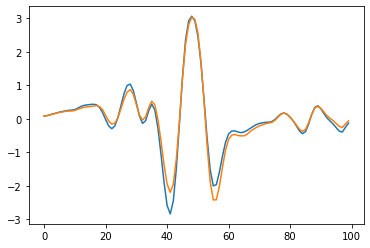

In [19]:
plt.plot(test)
plt.plot(reconstruction[0])

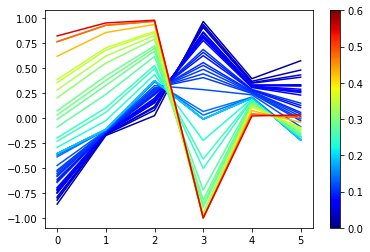

In [20]:
for i in range(len(val_dataset)):
    absorbption, fat = val_dataset[i]
    with torch.no_grad():
        latent_space = model.encoder_pass(absorbption.unsqueeze(0))
    plt.plot(latent_space[0], color=m.to_rgba(fat.item()))
plt.colorbar(m)

Il semble qu'il existe au moins une variable explicative évidente 

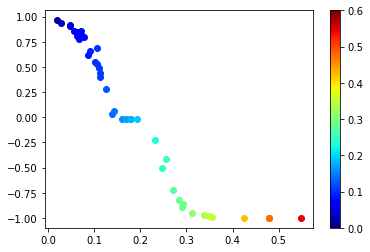

In [21]:
test_simple = []
for i in range(len(val_dataset)):
    absorbption, fat = val_dataset[i]
    with torch.no_grad():
        reco_abs = model.forward(absorbption.unsqueeze(0))
        latent_space = model.encoder_pass(absorbption.unsqueeze(0))
        test_simple.append(latent_space[0, 3].item())
        
    plt.scatter(fat, test_simple[-1], color=m.to_rgba(fat.item()))
plt.colorbar(m)

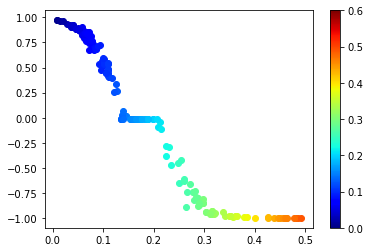

In [22]:
test_simple = []
for i in range(len(train_dataset)):
    absorbption, fat = train_dataset[i]
    with torch.no_grad():
        reco_abs = model.forward(absorbption.unsqueeze(0))
        latent_space = model.encoder_pass(absorbption.unsqueeze(0))
        test_simple.append(latent_space[0, 3].item())
        
    plt.scatter(fat, test_simple[-1], color=m.to_rgba(fat.item()))
plt.colorbar(m)

In [23]:
X_train = []
for i in range(len(train_dataset)):
    absorbption, fat = train_dataset[i]
    with torch.no_grad():
        reco_abs = model.forward(absorbption.unsqueeze(0))
        latent_space = model.encoder_pass(absorbption.unsqueeze(0))
        X_train.append(latent_space.numpy())

X_train = np.concatenate(X_train, axis=0)

In [24]:
X_test = []
for i in range(len(val_dataset)):
    absorbption, fat = val_dataset[i]
    with torch.no_grad():
        reco_abs = model.forward(absorbption.unsqueeze(0))
        latent_space = model.encoder_pass(absorbption.unsqueeze(0))
        X_test.append(latent_space.numpy())

X_test = np.concatenate(X_test, axis=0)

In [25]:
X_train.shape

(173, 6)

# Faisons du vieux avec du neuf

In [26]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [27]:
param_grid = [{
    "alpha":  np.linspace(1e-8, 1e-5, 200),
    "kernel": ['poly', 'polynomial', 'rbf'],
    "degree": np.arange(1,5)
}]

In [28]:
kkr = KernelRidge()

In [29]:
scores = ['r2']

In [30]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(estimator=kkr, param_grid=param_grid, cv=4,
                       scoring='%s' % score, n_jobs=10)
    clf.fit(X_train, y_train)
    print(clf.best_params_)
    print(clf.best_score_)

# Tuning hyper-parameters for r2



/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solut

/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solut

/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solut

/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.82191e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.24346e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge

/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.35449e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in sol

/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.66621e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=6.10806e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge

/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=7.15287e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=9.86709e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=8.98949e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3

/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=9.86709e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=7.70224e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.77141e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.03101e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.20573e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.96059e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.03578e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.02605e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=6.954e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=7.30236e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.35205e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9

/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.87e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=9.66292e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=6.68915e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=7.04538e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/ho

/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.76311e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.64939e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=8.23855e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.0859e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/

/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.42911e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=9.80472e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.28919e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.81511e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.26692e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.3438e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.07689e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.45633e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/

/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=8.05473e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.92734e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=6.81394e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.89777e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.8684e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.67694e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.8038e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.68811e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/h

{'alpha': 3.875477386934673e-06, 'degree': 1, 'kernel': 'rbf'}
0.9884903114835422


/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.11737e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.72265e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.61886e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.63441e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


In [31]:
kkr = KernelRidge(**clf.best_params_)

In [32]:
kkr.fit(X_train, y_train)

KernelRidge(alpha=3.875477386934673e-06, degree=1, kernel='rbf')

In [33]:
kkr.score(X_test, y_test)

0.9942385541792136

In [34]:
def SEP(pred, target):
    return np.sqrt(np.mean((pred-target)**2))

In [35]:
y_pred = kkr.predict(X_test)

In [36]:
SEP(y_pred, y_test)

1.0153300537613636

# Test du MLP avec l'espace latent de l'AE déja entraîné avec du EarlyStopping

In [37]:
pl_regressor = pl_mlp(model)
trainer_MLP = pl.Trainer(max_epochs=300, callbacks=[EarlyStopping(monitor="val_loss", patience=3)])

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [38]:
trainer_MLP.fit(pl_regressor, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)



  | Name           | Type    | Params
-------------------------------------------
0 | latent_creator | tiny_AE | 7.0 K 
1 | regressor      | mlp     | 91    
-------------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)


Epoch 0:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 11/14 [00:00<00:00, 163.54it/s, loss=0.225, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 1:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 11/14 [00:00<00:00, 160.51it/s, loss=0.227, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 2:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 11/14 [00:00<00:00, 151.05it/s, loss=0.225, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 3:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 11/14 [00:00<00:00, 160.32it/s, loss=0.224, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 4:  79%|██████████████████████████████████████████████████████

Epoch 18:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 169.18it/s, loss=0.202, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 19:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 160.29it/s, loss=0.201, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 20:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 156.87it/s, loss=0.199, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 21:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 149.51it/s, loss=0.198, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 22:  79%|█████████████████████████████████████████████████████

Epoch 36:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 147.53it/s, loss=0.175, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 37:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 168.55it/s, loss=0.174, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 38:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 174.98it/s, loss=0.173, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 39:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 168.58it/s, loss=0.171, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 40:  79%|█████████████████████████████████████████████████████

Epoch 54:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 154.17it/s, loss=0.147, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 55:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 151.48it/s, loss=0.145, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 56:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 175.84it/s, loss=0.143, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 57:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 152.86it/s, loss=0.141, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 58:  79%|█████████████████████████████████████████████████████

Epoch 72:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 164.55it/s, loss=0.112, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 73:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 11/14 [00:00<00:00, 194.70it/s, loss=0.11, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 74:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 193.59it/s, loss=0.107, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 75:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 166.70it/s, loss=0.105, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 76:  79%|█████████████████████████████████████████████████████

Epoch 90:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 163.13it/s, loss=0.0686, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 91:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 180.51it/s, loss=0.067, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 92:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 151.19it/s, loss=0.0652, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 93:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 155.49it/s, loss=0.0629, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 94:  79%|█████████████████████████████████████████████████████

Epoch 108:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 170.65it/s, loss=0.0404, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 109:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 152.39it/s, loss=0.0392, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 110:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 147.97it/s, loss=0.0387, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 111:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 156.28it/s, loss=0.0376, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 112:  79%|████████████████████████████████████████████████████

Epoch 126:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 198.22it/s, loss=0.0235, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 127:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 209.83it/s, loss=0.0229, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 128:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 176.36it/s, loss=0.0224, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 129:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 185.75it/s, loss=0.0218, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 130:  79%|████████████████████████████████████████████████████

Epoch 144:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 153.24it/s, loss=0.0143, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 145:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 161.86it/s, loss=0.0132, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 146:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 171.37it/s, loss=0.0132, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 147:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 167.92it/s, loss=0.0132, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 148:  79%|████████████████████████████████████████████████████

Epoch 162:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 163.74it/s, loss=0.0101, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 163:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 150.18it/s, loss=0.00976, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 164:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 163.35it/s, loss=0.00876, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 165:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 183.50it/s, loss=0.00815, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 166:  79%|████████████████████████████████████████████████████

Epoch 180:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 166.03it/s, loss=0.00628, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 181:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 147.30it/s, loss=0.00543, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 182:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 154.70it/s, loss=0.00587, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 183:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 155.85it/s, loss=0.00573, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 184:  79%|████████████████████████████████████████████████████

Epoch 198:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 174.05it/s, loss=0.00433, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 199:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 155.60it/s, loss=0.00437, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 200:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 177.49it/s, loss=0.00443, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 201:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 167.49it/s, loss=0.00502, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 202:  79%|████████████████████████████████████████████████████

Epoch 216:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 166.89it/s, loss=0.00464, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 217:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 159.77it/s, loss=0.0047, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 218:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 162.54it/s, loss=0.00458, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 219:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 154.87it/s, loss=0.00356, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 220:  79%|████████████████████████████████████████████████████

Epoch 234:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 157.55it/s, loss=0.00403, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 235:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 156.48it/s, loss=0.00326, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 236:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 158.53it/s, loss=0.0034, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 237:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 153.71it/s, loss=0.00408, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 238:  79%|████████████████████████████████████████████████████

Epoch 252:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 189.51it/s, loss=0.00382, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 253:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 168.91it/s, loss=0.00366, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 254:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 165.64it/s, loss=0.00218, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 255:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 165.58it/s, loss=0.00364, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 256:  79%|████████████████████████████████████████████████████

Epoch 270:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 166.41it/s, loss=0.00253, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 271:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 193.24it/s, loss=0.00259, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 272:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 166.31it/s, loss=0.00255, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 273:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 152.99it/s, loss=0.00276, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 274:  79%|████████████████████████████████████████████████████

Epoch 288:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 145.45it/s, loss=0.00322, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 289:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 188.53it/s, loss=0.003, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 290:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11/14 [00:00<00:00, 182.07it/s, loss=0.00321, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 291:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 11/14 [00:00<00:00, 158.57it/s, loss=0.0038, v_num=101]
Validating: 0it [00:00, ?it/s]
Epoch 292:  79%|████████████████████████████████████████████████████

Il n'y a pas eu ré entrainement de l'AE

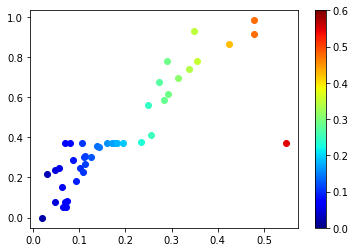

In [39]:
test_simple = []
for i in range(len(val_dataset)):
    absorbption, fat = val_dataset[i]
    with torch.no_grad():
        latent_space = pl_regressor.latent_creator.encoder_pass(absorbption.unsqueeze(0))
        test_simple.append(latent_space[0,2].item())
        
    plt.scatter(fat, test_simple[-1], color=m.to_rgba(fat.item()))
plt.colorbar(m)

In [40]:
y_pred = []
y_true = []
pl_regressor.eval()
for i in range(len(val_dataset)):
    absorbption, fat = val_dataset[i]
    y_true.append(fat)
    with torch.no_grad():
        y_hat = pl_regressor.forward(absorbption.unsqueeze(0))
        y_pred.append(y_hat[0])
y_pred = torch.cat(y_pred, dim=0)
y_true = torch.cat(y_true, dim=0)


In [41]:
100*SEP(y_pred.numpy(), y_true.numpy())

3.6504872143268585

# Entrainement parallele

Ici un entrainement qui consiste à entrainer conjointement l'AE et le MLP. L'idée n'est pas d'utiliser le MLP a l'issue, mais d'exploiter un espace latent bien mieux défini pour la tâche

In [42]:
pl_par = pl_parallel()
trainer_parallel = pl.Trainer(max_epochs=10000, callbacks=[EarlyStopping(monitor="val_loss", patience=4)])

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [43]:
trainer_parallel.fit(pl_par, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)



  | Name      | Type    | Params
--------------------------------------
0 | AE        | tiny_AE | 7.0 K 
1 | regressor | mlp     | 91    
--------------------------------------
7.0 K     Trainable params
0         Non-trainable params
7.0 K     Total params
0.028     Total estimated model params size (MB)


Epoch 0:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 11/14 [00:00<00:00, 134.63it/s, loss=0.682, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 1:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 11/14 [00:00<00:00, 138.14it/s, loss=0.681, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 2:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 11/14 [00:00<00:00, 133.72it/s, loss=0.676, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 3:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 11/14 [00:00<00:00, 125.69it/s, loss=0.673, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 4:  79%|██████████████████████████████████████████████████████

Epoch 18:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 142.70it/s, loss=0.615, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 19:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 148.91it/s, loss=0.611, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 20:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 142.17it/s, loss=0.609, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 21:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 144.73it/s, loss=0.606, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 22:  79%|█████████████████████████████████████████████████████

Epoch 36:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 137.68it/s, loss=0.552, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 37:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 139.68it/s, loss=0.548, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 38:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 138.33it/s, loss=0.545, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 39:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 151.29it/s, loss=0.542, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 40:  79%|█████████████████████████████████████████████████████

Epoch 54:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 151.87it/s, loss=0.492, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 55:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 145.35it/s, loss=0.487, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 56:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 137.78it/s, loss=0.484, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 57:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 159.24it/s, loss=0.481, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 58:  79%|█████████████████████████████████████████████████████

Epoch 72:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 148.43it/s, loss=0.447, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 73:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 127.08it/s, loss=0.443, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 74:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 157.49it/s, loss=0.437, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 75:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 145.26it/s, loss=0.437, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 76:  79%|█████████████████████████████████████████████████████

Epoch 90:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 152.13it/s, loss=0.399, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 91:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 137.14it/s, loss=0.398, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 92:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 143.51it/s, loss=0.395, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 93:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 152.87it/s, loss=0.393, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 94:  79%|█████████████████████████████████████████████████████

Epoch 108:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 133.24it/s, loss=0.367, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 109:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 149.69it/s, loss=0.363, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 110:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 164.77it/s, loss=0.358, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 111:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 161.62it/s, loss=0.356, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 112:  79%|████████████████████████████████████████████████████

Epoch 126:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 157.00it/s, loss=0.329, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 127:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 143.54it/s, loss=0.321, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 128:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 149.99it/s, loss=0.325, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 129:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 11/14 [00:00<00:00, 147.51it/s, loss=0.33, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 130:  79%|████████████████████████████████████████████████████

Epoch 144:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 166.12it/s, loss=0.295, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 145:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 144.69it/s, loss=0.296, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 146:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 120.99it/s, loss=0.297, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 147:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 154.08it/s, loss=0.297, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 148:  79%|████████████████████████████████████████████████████

Epoch 162:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 141.90it/s, loss=0.273, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 163:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 147.49it/s, loss=0.269, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 164:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 142.40it/s, loss=0.272, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 165:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 151.24it/s, loss=0.271, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 166:  79%|████████████████████████████████████████████████████

Epoch 180:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 157.88it/s, loss=0.251, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 181:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 138.43it/s, loss=0.252, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 182:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 146.78it/s, loss=0.253, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 183:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 141.37it/s, loss=0.252, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 184:  79%|████████████████████████████████████████████████████

Epoch 198:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 135.40it/s, loss=0.241, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 199:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 143.98it/s, loss=0.237, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 200:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 144.78it/s, loss=0.236, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 201:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11/14 [00:00<00:00, 150.94it/s, loss=0.236, v_num=102]
Validating: 0it [00:00, ?it/s]
Epoch 202:  79%|████████████████████████████████████████████████████

In [44]:
pl_par.eval()

pl_parallel(
  (AE): tiny_AE(
    (encoder_in): Linear(in_features=100, out_features=32, bias=True)
    (drop_enc): Dropout(p=0.5, inplace=False)
    (encoder_out): Linear(in_features=32, out_features=6, bias=True)
    (decoder_in): Linear(in_features=6, out_features=32, bias=True)
    (decorder_out): Linear(in_features=32, out_features=100, bias=True)
    (drop_dec): Dropout(p=0.5, inplace=False)
  )
  (regressor): mlp(
    (linear_in): Linear(in_features=6, out_features=6, bias=True)
    (linear_mid): Linear(in_features=6, out_features=6, bias=True)
    (linear_out): Linear(in_features=6, out_features=1, bias=True)
  )
)

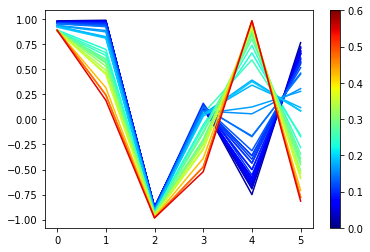

In [45]:
for i in range(len(val_dataset)):
    absorbption, fat = val_dataset[i]
    with torch.no_grad():
        latent_space = pl_par.AE.encoder_pass(absorbption.unsqueeze(0))
    plt.plot(latent_space[0], color=m.to_rgba(fat.item()))
    #plt.scatter(fat, latent_space[0, 1], color=m.to_rgba(fat.item()))
plt.colorbar(m)

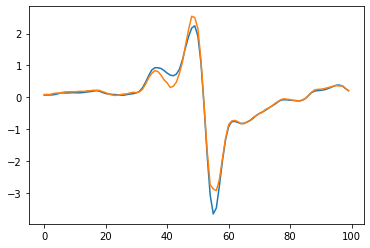

In [46]:
absorbption, fat = val_dataset[15]

with torch.no_grad():
        reconstruction, _ = pl_par.AE(absorbption.unsqueeze(0))
plt.plot(absorbption)
plt.plot(reconstruction[0])

In [47]:
X_train = []
for i in range(len(train_dataset)):
    absorbption, fat = train_dataset[i]
    with torch.no_grad():
        X_train.append(pl_par.AE.encoder_pass(absorbption.unsqueeze(0)))
X_train = torch.cat(X_train, dim=0)

In [48]:
y_pred = []
y_true = []
X_test = []
pl_par.eval()
for i in range(len(val_dataset)):
    absorbption, fat = val_dataset[i]
    y_true.append(fat)
    with torch.no_grad():
        y_hat, _ = pl_par.forward(absorbption.unsqueeze(0))
        X_test.append(pl_par.AE.encoder_pass(absorbption.unsqueeze(0)))
        y_pred.append(y_hat[0])
y_pred = torch.cat(y_pred, dim=0)
y_true = torch.cat(y_true, dim=0)
X_test = torch.cat(X_test, dim=0)


In [49]:
100*SEP(y_pred.numpy(), y_true.numpy())

8.412063121795654

In [50]:
X_train.shape

torch.Size([173, 6])

In [51]:
param_grid = [{
    "alpha":  np.linspace(1e-5, 1e-1, 200),
    "kernel": ['poly', 'polynomial', 'rbf'],
    "degree": np.arange(1,5)
}]

In [52]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(estimator=kkr, param_grid=param_grid, cv=4,
                       scoring='%s' % score, n_jobs=10)
    clf.fit(X_train.numpy(), y_train)
    print(clf.best_params_)
    print(clf.best_score_)

# Tuning hyper-parameters for r2



/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.92966e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.29435e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.71577e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/shaheen/anaconda3/envs/ppl/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.81374e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


{'alpha': 0.000512462311557789, 'degree': 3, 'kernel': 'poly'}
0.9944276761939399


In [53]:
kkr = KernelRidge(**clf.best_params_)

In [54]:
kkr.fit(X_train.numpy(), y_train)

KernelRidge(alpha=0.000512462311557789, kernel='poly')

In [55]:
kkr.score(X_test.numpy(), y_test)

0.9964555028857269

In [56]:
y_hat = kkr.predict(X_test.numpy())

In [57]:
SEP(y_hat, y_test)

0.796377192824892

Pas super... il vaut mieux miser sur une base FFT